# Introduction

The Future Sales competition is the final assesment in the 'How to win a Data Science' course in the Advanced Machine Learning specialisation from HSE University, Moscow. The aim is to predict the monthly sales of items in specific shops, given historical data. The sale counts are clipped between 0 and 20.

In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# Load Data

In [45]:
# load data
items=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
shops=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
cats=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
train=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

# 1. Data Cleaning

We'll remove outliers, clean up some of the raw data and add some new variables to it.

# Remove outliers

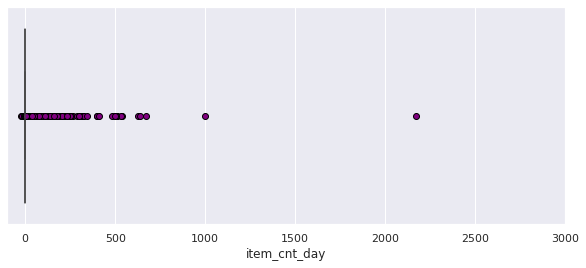

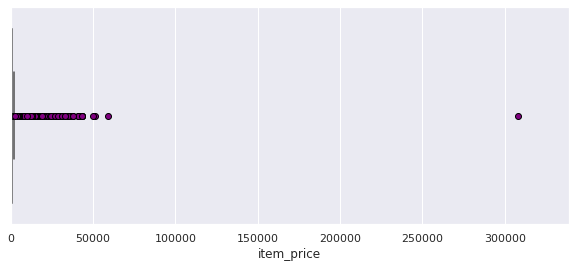

In [46]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

We'll remove the obvious outliers in the dataset - the items that sold more than 1000 in one day and the item with price greater than 300,000.

In [47]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

Remove any rows from train where item price is negative - these could be refunds. Also make zero and item_cnt_day values less than one, to remove negative values.

In [48]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

# Cleaning Shop Data

Several of the shops look like duplicates of each other. This could be down to shops re-opening or possibly moving store location on the same street or shopping centre.

In [49]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Clean up some shop names and add 'city' and 'category' to shops df.

In [50]:
# shops.category.unique()

In [51]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".

In [52]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [53]:
# shops.city.unique() 

In [54]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

# Cleaning Item Category Data

In [55]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [56]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [57]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

# Cleaning Item Data

In [58]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [59]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

Clean item names.

In [60]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


Clean item type

In [61]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [62]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [63]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [64]:
items.name3.unique()

array([1331,   42, 1011, ...,  758,  759, 1281])

# Preprocessing

Create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

In [65]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935840,10.10.2015,33,25,7409,299.00,1.0
2935841,09.10.2015,33,25,7460,299.00,1.0
2935842,14.10.2015,33,25,7459,349.00,1.0
2935843,22.10.2015,33,25,7440,299.00,1.0


product()函数也可以用于求取一个可迭代对象中自己各个元素的全排列组合

因为每一个月，每个shop种所出售的item情况不同，很多时候可能是0（没有这个记录），但是这都要参与到我们的建模中。所以我们要先将所有的情况都列出来。然后再与现有数据合并，缺失的数据就填补为0，这样构建数据集

In [66]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )


In [67]:
# matrix  # 每月的所有shop和item的组合（笛卡尔积）

In [68]:

matrix = pd.DataFrame( np.vstack(matrix), columns = cols ) # 堆叠
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts # 运行了多少秒？

9.614757061004639

In [69]:
# add revenue to train df 收入
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [70]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True) # 这一步重置索引，直接把层级索引转换为列，学到了
matrix = pd.merge( matrix, group, on = cols, how = "left" ) # 转换后，二者就可以merge了
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16) # 填补缺失值
time.time() - ts

3.7418928146362305

Create a test set for month 34.

这里在添加新东西的时候常常设置格式，我没有这个习惯，可以学习一下

In [71]:
# 对测试集添加一个月份列，同时设置一下三列的数据格式
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

Concatenate train and test sets.

In [72]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols) # 按三列，添加？
matrix.fillna( 0, inplace = True )
time.time() - ts

0.038741111755371094

Add shop, items and categories data onto matrix df.

In [73]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

2.8377559185028076

In [74]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code
0,0,2,19,0.0,4,0,40,4,42,4,5
1,0,2,27,1.0,4,0,19,76,42,10,3
2,0,2,28,0.0,4,0,30,107,42,55,3
3,0,2,29,0.0,4,0,23,123,42,16,3
4,0,2,32,0.0,4,0,40,4,42,4,5
...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7
11128000,34,45,16188,0.0,4,20,64,4,42,42,8
11128001,34,45,15757,0.0,4,20,55,4,42,2,7
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5


Feature Engineering

* Add lag features to matrix df.

In [75]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code
0,0,2,19,0.0,4,0,40,4,42,4,5
1,0,2,27,1.0,4,0,19,76,42,10,3
2,0,2,28,0.0,4,0,30,107,42,55,3
3,0,2,29,0.0,4,0,23,123,42,16,3
4,0,2,32,0.0,4,0,40,4,42,4,5
...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7
11128000,34,45,16188,0.0,4,20,64,4,42,42,8
11128001,34,45,15757,0.0,4,20,55,4,42,2,7
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5


In [76]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [77]:
# matrix

Add item_cnt_month lag features.

In [78]:
# ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] ) # 添加该商店的该商品一个月、两个月、三个月的销量
time.time() - ts

item_cnt_month


18.67425799369812

Add the previous month's average item_cnt.
上个月的平均销量

In [79]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,2,19,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN
1,0,2,27,1.0,4,0,19,76,42,10,3,NaN,NaN,NaN
2,0,2,28,0.0,4,0,30,107,42,55,3,NaN,NaN,NaN
3,0,2,29,0.0,4,0,23,123,42,16,3,NaN,NaN,NaN
4,0,2,32,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,1.0,0.0,0.0
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.0,0.0,NaN
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.0,0.0,0.0
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.0,0.0,0.0


In [80]:
ts = time.time()
# 计算每个月的平均销量（这个月的所有大杂烩）
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

# 在matrix中添加  前一个月的平均销量 作为一个lag feature
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


7.981454610824585

Add lag values of item_cnt_month for month / item_id.

In [81]:
ts = time.time()
# 计算每个月该商品的平均销量（这个月的该商品）
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

# 添加 前三个月该商品的平均销量
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


19.239197492599487

Add lag values for item_cnt_month for every month / shop combination.

In [82]:
ts = time.time()
# 计算 该店铺的平均销量（泰迪杯里没有店铺概念）
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


date_shop_avg_item_cnt


19.608582496643066

Add lag values for item_cnt_month for month/shop/item.

In [83]:
ts = time.time()
# 计算该店铺、该商品的平均销量（泰迪杯没有店铺概念）
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


date_shop_item_avg_item_cnt


27.87403392791748

Add lag values for item_cnt_month for month/shop/item subtype.

In [84]:
ts = time.time()
# 计算该店铺，该子类商品房 月销售量
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

# 添加上一月的
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


9.985163450241089

Add lag values for item_cnt_month for month/city.

In [85]:
ts = time.time()
# 添加该城市的月销售量
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

# 添加上一月的
matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


10.033993005752563

Add lag values for item_cnt_month for month/city/item.

In [86]:
ts = time.time()
# 添加该城市该商品的月销售量
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
# 添加上一月的
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


15.753189086914062

* Add average item price on to matix df. 
* Add lag values of item price per month.
* Add delta price values - how current month average pirce relates to global average.

前面算的一直是销量，这里开始添加的特征是价格
虽然要求预测的是销量，但是价格与销量息息相关，也是重要的特征

Price trend features，最后只有一个'delta_price_lag'特征，具体看代码注释

In [92]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'shop_category', 'shop_city', 'item_category_id', 'name2', 'name3',
       'subtype_code', 'type_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_item_avg_item_cnt_lag_1',
       'date_shop_item_avg_item_cnt_lag_2',
       'date_shop_item_avg_item_cnt_lag_3',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'delta_price_lag'],
      dtype='object')

In [89]:
ts = time.time()
# 添加该商品的平均价格
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)



# 添加该商品每月的平均价格，前三个月的
group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] ) # 添加价格
for i in lags: # 添加价格趋势
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]


def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

# 这个函数看起来像是，该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

# 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_price_lag
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


316.6582293510437

* Add total shop revenue per month to matix df. 
* Add lag values of revenue per month.
* Add delta revenue values - how current month revenue relates to global average.

我们已经知道validation set和test set都会出现train set所没有的新商品，借助商店revenue趋势特征可以帮助算法预测新商品在现有店铺的销量

该商店的特征同上，但是泰迪杯没有这样的商店列，所以可以用大类或者小类的商品销售趋势替代

In [93]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


11.288511514663696

Add month and number of days in each month to matrix df.

添加月份、和该月有多少天的两个特征

In [94]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add the month of each shop and item first sale.

'item_shop_last_sale'和'item_last_sale'用以纪录距离最近一次销售之间隔了几个月，通过它可以和之前月份的数据建立关联。'item_shop_first_sale'和'item_first_sale'则是用于表示新商品的特征


该商品从第一个销售到现在有几个月了

In [95]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

1.4358084201812744

Delete first three months from matrix. They don't have lag values.

In [96]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.6696248054504395

In [100]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
shop_category,4.000000,4.000000,4.0,4.000000,4.000000
shop_city,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
name2,76.000000,107.000000,123.0,4.000000,4.000000
name3,42.000000,42.000000,42.0,42.000000,562.000000
subtype_code,10.000000,55.000000,16.0,4.000000,1.000000


# Modelling

In [101]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [102]:
data = matrix.copy()  # 好习惯，使用copy，不要直接=
del matrix
gc.collect() # 好习惯，释放内存

22

In [105]:
data[data["date_block_num"]==34].shape

(214200, 33)

Use month 34 as validation for training.

In [106]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [107]:
# 题目销量要求限制在0到20之间
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [108]:
# 划分完就删删删
del data
gc.collect();

In [109]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[04:55:44] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18233	validation_1-rmse:1.11775
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12933	validation_1-rmse:1.07887
[2]	validation_0-rmse:1.08586	validation_1-rmse:1.04672


KeyboardInterrupt: 

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))